<a href="https://colab.research.google.com/github/deanwampler/RISECamp2019Tutorials/blob/master/exercise_2_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Accelerated Hyperparameter Tuning For PyTorch

### In this tutorial, we'll show you how to leverage advanced hyperparameter tuning techniques with Tune.

<img src="tune-arch-simple.png" alt="Tune Logo" width="600"/>

Specifically, we'll leverage ASHA and Bayesian Optimization (via HyperOpt) without modifying your underlying code.

Tune is a scalable framework for model training and hyperparameter search with a focus on deep learning and deep reinforcement learning.

* **Code**: https://github.com/ray-project/ray/tree/master/python/ray/tune 
* **Examples**: https://github.com/ray-project/ray/tree/master/python/ray/tune/examples
* **Documentation**: http://ray.readthedocs.io/en/latest/tune.html
* **Mailing List** https://groups.google.com/forum/#!forum/ray-dev

In [0]:
## If you are running on Google Colab, uncomment below to install the necessary dependencies 
## before beginning the exercise.

print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q ray[debug]

# # A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash.")
import os
os._exit(0)

Setting up colab environment
     |████████████████████████████████| 75.9MB 411kB/s 
     |████████████████████████████████| 1.3MB 4.3MB/s 
     |████████████████████████████████| 71kB 27.0MB/s 
     |████████████████████████████████| 2.8MB 7.1MB/s 


In [1]:
# # If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


### Exercise 1: PyTorch Imports Code

In [2]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders

import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("ggplot")

datasets.MNIST("~/data", train=True, download=True)

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [05:14<00:00, 40895.38it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



0it [00:00, ?it/s]


 85%|████████▌ | 24576/28881 [00:01<00:00, 24948.25it/s]
32768it [00:01, 26964.54it/s]                           
0it [00:00, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



 24%|██▍       | 393216/1648877 [00:12<01:43, 12157.39it/s]
9920512it [05:30, 40895.38it/s]                             
 99%|█████████▉| 1638400/1648877 [00:58<00:00, 50260.01it/s]

0it [00:00, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 21564.44it/s]            

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/data
    Split: Train

We import some helper functions above. For example, `train` is simply a for loop over the data loader.

```python
    def train(model, optimizer, train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx * len(data) > EPOCH_SIZE:
                return
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
```

In order to make decisions in the middle of training, we need to let the training function notify Tune. The ``tune.track`` API allows Tune to keep track of current results.

**TODO**: Add `tune.track.log(mean_accuracy=acc)` within the training loop. 

In [0]:
def train_mnist(config):
    model = ConvNet()
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])

    for i in range(20):
        train(model, optimizer, train_loader)  # Train for 1 epoch
        acc = test(model, test_loader)  # Obtain validation accuracy.
        # TODO: Add tune.track.log(mean_accuracy=acc) here
        tune.track.log(mean_accuracy=acc) 
        if i % 5 == 0:
            torch.save(model, "./model.pth") # This saves the model to the trial directory

### Example Trial Run

Let's run 1 trial, randomly sampling from a uniform distribution for learning rate and momentum. 

A "trial" is the execution of training using a set of hyperparameters. An **experiment** is a set of trials (i.e., a hyperparameter search).

Run the below cell to run Tune. 

#### This is one random sample and should perform poorly.

In [4]:
np.random.seed(1)
search_space = {
    "lr": tune.loguniform(0.0001, 0.1),
    "momentum": tune.uniform(0.1, 0.9)
}

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


analysis = tune.run(
    train_mnist, 
    config=search_space, 
    verbose=1,
    name="train_mnist",  # This is used to specify the logging directory.
    stop={"mean_accuracy": 0.98}  # This will stop the trial 
)

Trial name,ID,status,loc,momentum,lr,iter,total time (s),acc
train_mnist_345fcc00,345fcc00,TERMINATED,pid=376,0.899232,0.000242311,19,5.86489,0.434375


2019-10-17 19:20:48,962	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


#### Plot the performance of this trial.

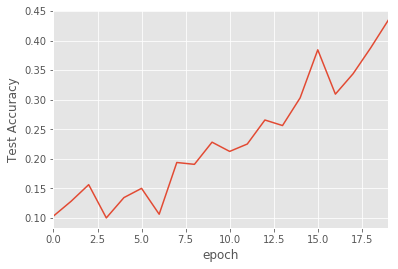

In [5]:
dfs = analysis.fetch_trial_dataframes()
[d.mean_accuracy.plot() for d in dfs.values()]
plt.xlabel("epoch"); plt.ylabel("Test Accuracy"); 

### Exercise 2: Efficient Grid Search with Early Stopping


Tune provides a `tune.grid_search` primitive to pass into `tune.run` as follows:
```python
tune.run(config={"variable": tune.grid_search([1, 2, 3])})
```

From this, Tune will run 3 trials, evaluating each value in the grid search. To specify a multi-dimensional grid search, you can use `tune.grid_search` on multiple variables:


```python
tune.run(config={
    "variable1": tune.grid_search([1, 2, 3]),
    "variable2": tune.grid_search([1, 2, 3]),
    "variable3": tune.grid_search([1, 2, 3]),
    "variable4": tune.grid_search([1, 2, 3]),
})
```

This will generate a total $3 * 3 * 3 * 3 = 81$ trials.

Below, we will set up a grid search over the "lr" and "momentum" hyperparameters.

#### FAQ: what is "lr"?

"lr" stands for "learning rate".
Deep learning neural networks are trained using the stochastic gradient descent (SGD) algorithm.

SGD estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

(Taken from https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

####  FAQ: what is "momentum"?

Momentum is a hyperparameter to the SGD aglorithm.

An exponentially weighted average of the prior updates to the weight can be included when the weights are updated. This change to stochastic gradient descent is called “momentum” and adds inertia to the update procedure, causing many past updates in one direction to continue in that direction in the future.

(Taken from https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)

### Instructions: 
**TODO**: Specify a multi-dimensional grid search, gridding over `lr` and `momentum`. Choose 5 values between 0.001 to 0.9 for both values.


In [0]:
# TODO: Specify a multi-dimensional grid search, gridding over lr and momentum. 
# Choose 5 values between 0.001 to 0.9 for both values.
hyperparameter_space = {
    "lr": tune.grid_search([0.001, 0.1, 0.3, 0.6, 0.9]),
    "momentum":  tune.grid_search([0.001, 0.1, 0.3, 0.6, 0.9])

}

assert "grid_search" in hyperparameter_space.get("lr") 
assert "grid_search" in hyperparameter_space.get("momentum")

#### Using an early-stopping algorithm

An efficient hyperparameter optimization avoids training low-performing trials. This is one of the main inefficiencies of a grid search. 

In Tune, we can avoid this by using state-of-the-art search algorithms such as Asynchronous Successive Halving Algorithm (ASHA). ASHA is a scalable algorithm for principled early stopping. How does it work? On a high level, it terminates trials that are less promising and allocates more time and resources to more promising trials. 

    The successive halving algorithm begins with all candidate configurations in the base "halving" iteration and proceeds as follows:

        1. Uniformly allocate a budget to a set of candidate hyperparameter configurations in a given "halving" iteration.
        2. Evaluate the performance of all candidate configurations.
        3. Promote the top half of candidate configurations to the next "halving" iteration.
        4. Double the budget per configuration for the next "halving" iteration and repeat until one configurations remains. 
        
A textual representation ("iter" stands for *'"halving" iteration'*):
    
           | Configurations | Epochs per 
           | Remaining      | Configuration
    ---------------------------------------
    iter 1 | 27             | 1
    iter 2 | 9              | 3
    iter 3 | 3              | 9
    iter 4 | 1              | 27

(from https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/ for the ASHA blog post and paper)

### Instructions: 
**TODO**: Set up ASHA.

1) Create an ASHA "Scheduler" (ASHA). A scheduler decides which trials to run, stop, or pause. 
```python
from ray.tune.schedulers import ASHAScheduler

custom_scheduler = ASHAScheduler(
    metric='mean_accuracy',
    mode="max",
    grace_period=1,
)
```

*Note: Read the documentation on this step at https://ray.readthedocs.io/en/latest/tune-schedulers.html#asynchronous-hyperband or call ``help(tune.schedulers.ASHAScheduler)`` to learn more about the ASHA Scheduler*



#### FAQ: How do I debug things in Tune?

The `error file` column will show up in the output. Run the below cell with the ``error file`` path to diagnose your issue.

```
! cat /home/ubuntu/tune_iris/tune_iris_c66e1100_2019-10-09_17-13-24x_swb9xs/error_2019-10-09_17-13-29.txt
```

In [10]:
from ray.tune.schedulers import ASHAScheduler

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


custom_scheduler = ASHAScheduler(
    metric='mean_accuracy',
    mode="max",
    grace_period=1,
)  # TODO: Add a ASHA as custom scheduler here


analysis = tune.run(
    train_mnist, 
    scheduler=custom_scheduler, 
    config=hyperparameter_space, 
    verbose=1,
    name="train_mnist"  # This is used to specify the logging directory.
)

Trial name,ID,status,loc,momentum,lr,iter,total time (s),acc
train_mnist_6285ca34,6285ca34,TERMINATED,pid=613,0.001,0.001,16,16.1894,0.18125
train_mnist_6286cc5e,6286cc5e,TERMINATED,pid=614,0.001,0.1,19,15.5175,0.884375
train_mnist_6287917a,6287917a,TERMINATED,pid=652,0.001,0.3,19,19.8089,0.946875
train_mnist_6288790a,6288790a,TERMINATED,pid=678,0.001,0.6,1,3.4907,0.13125
train_mnist_62898a5c,62898a5c,TERMINATED,pid=703,0.001,0.9,1,1.8618,0.13125
train_mnist_628e75b2,628e75b2,TERMINATED,pid=695,0.1,0.001,1,2.68701,0.1
train_mnist_628ff82e,628ff82e,TERMINATED,pid=686,0.1,0.1,16,17.0458,0.903125
train_mnist_62904360,62904360,TERMINATED,pid=752,0.1,0.3,19,17.7347,0.91875
train_mnist_62918086,62918086,TERMINATED,pid=770,0.1,0.6,1,1.74579,0.09375
train_mnist_62928c2e,62928c2e,TERMINATED,pid=751,0.1,0.9,1,1.7201,0.34375


2019-10-17 19:30:49,280	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


#### Let's plot our results by wall-clock time and epoch. 

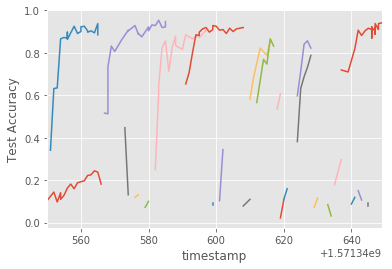

In [11]:
# Plot by wall-clock time

dfs = analysis.fetch_trial_dataframes()
# This plots everything on the same plot
ax = None
for d in dfs.values():
    ax = d.plot("timestamp", "mean_accuracy", ax=ax, legend=False)
plt.xlabel("timestamp"); plt.ylabel("Test Accuracy"); 

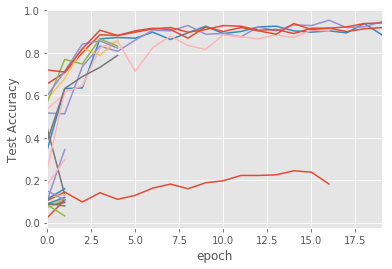

In [12]:
# Plot by epoch
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
plt.xlabel("epoch"); plt.ylabel("Test Accuracy"); 

### Exercise 3: Search Algorithms in Tune

Tune enables you to scale existing hyperparameter search libraries such as HyperOpt (https://github.com/hyperopt/hyperopt). In this setting, use the external library's hyperparameter space specification instead of Tune's configuration.

Search algorithms can limit the number of concurrent hyperparameters are being evaluated. This is necessary because sometimes the external library is more effective when evaluations are sequential.

### Instructions
**TODO:** Create a HyperOptSearch object by passing in a HyperOpt specific search space. Also enforce that only 1 trials can run concurrently:

```python
    hyperopt_search = HyperOptSearch(space, max_concurrent=1, metric="mean_accuracy", mode="max")
```

Then, plug in `HyperOptSearch` into `tune.run`.

In [13]:
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

# This is a HyperOpt specific hyperparameter space configuration.
space = {
    "lr": hp.loguniform("lr", -10, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

# TODO: Create a HyperOptSearch object by passing in a HyperOpt specific search space.
# Also enforce that only 1 trials can run concurrently.
hyperopt_search = HyperOptSearch(space, max_concurrent=1, metric="mean_accuracy", mode="max") # TODO: Change this

# We Remove the dir so that we can visualize tensorboard correctly
! rm -rf ~/ray_results/search_algorithm 
analysis = tune.run(
    train_mnist, 
    num_samples=10,  
    search_alg=hyperopt_search,  #  TODO: Change this
    verbose=1,
    name="search_algorithm"  # This is used to specify the logging directory.
)

Trial name,ID,status,loc,momentum,lr,iter,total time (s),acc
train_mnist_f4a89bbc,f4a89bbc,TERMINATED,pid=1090,0.256074,0.000237886,19,5.54795,0.14375
train_mnist_f4a98ba8,f4a98ba8,TERMINATED,pid=1109,0.714654,0.00274103,19,5.29423,0.8
train_mnist_f8cfd19c,f8cfd19c,TERMINATED,pid=1128,0.129799,0.00013955,19,5.43819,0.09375
train_mnist_fcdfdd7c,fcdfdd7c,TERMINATED,pid=1144,0.623093,0.000686011,19,5.41853,0.19375
train_mnist_01100cb4,01100cb4,TERMINATED,pid=1163,0.868216,0.000766776,19,5.1536,0.75625
train_mnist_0537886c,0537886c,TERMINATED,pid=1182,0.471714,9.80963e-05,19,5.36938,0.05625
train_mnist_091402c6,091402c6,TERMINATED,pid=1198,0.713229,0.00216679,19,5.13998,0.8125
train_mnist_0d10a6fe,0d10a6fe,TERMINATED,pid=1217,0.100898,7.74974e-05,19,5.29135,0.040625
train_mnist_11008a04,11008a04,TERMINATED,pid=1236,0.474992,0.0212834,19,5.08032,0.88125
train_mnist_1512b996,1512b996,TERMINATED,pid=1252,0.170123,0.0147431,19,4.90822,0.85


2019-10-17 19:34:18,856	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


## Extra - use Tensorboard for results

You can use TensorBoard to view trial performances. If the graphs do not load, click `Toggle All Runs`.

In [0]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir ~/ray_results/search_algorithm

Reusing TensorBoard on port 6006 (pid 1277), started 0:00:06 ago. (Use '!kill 1277' to kill it.)

# Extra: Using GPUs.

If your machine has a GPU, you can use the `resources_per_trial` argument to specify that the trial should use a GPU. This allows Tune to automatically set the `CUDA_VISIBLE_DEVICES` for the trial and enforce resource isolation (i.e., 1 trial per GPU at a time).

In [0]:
analysis = tune.run(
    train_mnist, 
    num_samples=10,  
    resources_per_trial={"GPU": 1},
    verbose=1,
    name="use_gpu"  # This is used to specify the logging directory.
)